In [3]:
!pip install cupy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 37.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 27.9 MB/s eta 0:00:00
  Using cached fastrlock-0.8.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (9.3 kB)
Using cached fastrlock-0.8.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (52 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for cupy: filename=cupy-13.1.0-cp311-cp311-linux_x86_64.whl size=76778309 sha256=63f37ff749aaf5830a9cd858bd97f706fd3c6c05492761ecde3fccca3fea47a3
  Stored in directory: /home/minyoungxi/.cache/pip/wheels/3d/4d/fc/b1328a08df91aeb2598d97f32bf6a6372736c39ab3a808f403
Successfully built cupy


In [13]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 17.8 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 49.3 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 52.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.1 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


In [14]:
import cupy as cp

# CuPy 배열 생성
a = cp.array([1, 2, 3, 4, 5])

# 배열의 장치 확인
print(a.device)  # Output: <CUDA Device 0>

<CUDA Device 0>


# CuPY + Nilearn

OASIS-3 데이터를 fMRIprep으로 전처리를 거친 후 Numpy 배열로 변환합니다. 

변환한 Numpy 배열을 다시 CuPy 배열로 변환하면 GPU로 전처리 연산이 가능합니다. 



In [24]:
import cupy as cp
import cupyx.scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image, plotting
from nilearn.image import new_img_like
import time

img_path = "/home/minyoungxi/MINYOUNGXI/XFL/derivatives/sub-OAS30002/ses-d2345/anat/sub-OAS30002_ses-d2345_desc-preproc_T1w.nii.gz"

# NIfTI 이미지 로드
img = image.load_img(img_path)

# NIfTI 이미지를 NumPy 배열로 변환
data = img.get_fdata()

# NumPy 배열을 CuPy 배열로 변환
data_cupy = cp.asarray(data)

# 전처리 전 원본 이미지 시각화
plotting.plot_anat(img, title="Original Image")

# GPU 사용 확인을 위한 메모리 정보 출력
device = cp.cuda.Device(0)
print(f"Using device: {device}")
print(f"Free memory: {device.mem_info[0] / 1024**2:.2f} MB, Total memory: {device.mem_info[1] / 1024**2:.2f} MB")

# 전처리 시작 시간 기록
start_time = time.time()

# 메디안 필터 적용
filtered_data_cupy = ndi.median_filter(data_cupy, size=3)

# 데이터 정규화 (z-정규화)
mean = cp.mean(filtered_data_cupy)
std = cp.std(filtered_data_cupy)
normalized_data_cupy = (filtered_data_cupy - mean) / std

# 전처리 종료 시간 기록
end_time = time.time()

# 전처리에 걸린 시간 계산
preprocessing_time = end_time - start_time
print(f"전처리에 걸린 시간: {preprocessing_time:.2f} 초")

# CuPy 배열을 NumPy 배열로 변환
final_data_np = cp.asnumpy(normalized_data_cupy)

# 새로운 NIfTI 이미지 생성
new_img = new_img_like(img, final_data_np)

# 전처리 후 이미지 시각화
plotting.plot_anat(new_img, title="Preprocessed Image")

# 두 이미지를 동일한 화면에 표시
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plotting.plot_anat(img, title="Original Image", axes=axes[0])
plotting.plot_anat(new_img, title="Preprocessed Image", axes=axes[1])
plt.show()

# 전처리 전후의 이미지 해상도 확인
original_shape = data.shape
processed_shape = final_data_np.shape
print(f"Original image shape: {original_shape}")
print(f"Processed image shape: {processed_shape}")

# 불필요한 데이터 제거
del data_cupy, filtered_data_cupy, normalized_data_cupy, final_data_np
cp._default_memory_pool.free_all_blocks()

# 간단한 벤치마크 테스트로 GPU 사용 확인
small_data = cp.random.random((1000, 1000))  # 작은 데이터셋 생성
start = cp.cuda.Event()
end = cp.cuda.Event()

start.record()
cp.dot(small_data, small_data)  # 예시 연산
end.record()

end.synchronize()
print(f"GPU 연산 시간: {cp.cuda.get_elapsed_time(start, end)} ms")


/home/minyoungxi/MINYOUNGXI/XFL/.conda/lib/python3.11/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


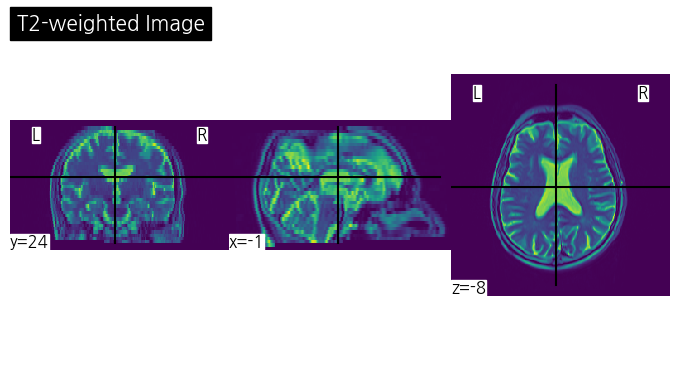

In [16]:
from nilearn import plotting, image

# 파일 경로 설정
nii_path = '/home/minyoungxi/Downloads/dbssus123-20240602_045938/OAS30002_MR_d2345/anat1/NIFTI/sub-OAS30002_ses-d2345_acq-TSE_T2w.nii.gz'

# NIfTI 이미지 로드
img = image.load_img(nii_path)

# 이미지 플로팅
plotting.plot_img(img, title="T2-weighted Image")
plotting.show()